In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
import matplotlib
import matplotlib.pyplot as plt

from models import *

import scipy.misc
import numpy as np
from random import choice, random, randint
import shutil, os

import PIL
import cv2

In [2]:
# Loading custom image set

SZ = 128

transform_train = transforms.Compose([
    transforms.Resize((SZ)),
    #transforms.CenterCrop(SZ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(SZ, pad_if_needed=True),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
    transforms.ToTensor(), 
])

transform_test = transforms.Compose([
    transforms.Resize((SZ)),
    #transforms.RandomCrop(64, pad_if_needed=True),
    transforms.CenterCrop(SZ),
    transforms.ToTensor(), 
])

#vid_id = "DJI_0007"
#dataset = datasets.ImageFolder(root='../../videos/'+vid_id, transform=transform) 

group_folder = "9.27_lazy_overhead"
dataset = datasets.ImageFolder(root='../../videos/'+group_folder+"/frames", transform=transform_train) # can simply create large dataset based on this hierarchical folder structure!
dataset_test = datasets.ImageFolder(root='../../videos/'+group_folder+"/frames", transform=transform_test) # can simply create large dataset based on this hierarchical folder structure!

#dataset = datasets.ImageFolder(root='../../videos/9.18.18_clearing/frames/DJI_0023_lr', transform=transform)
len(dataset.imgs)

229044

In [56]:
!ls '../../videos/9.27_lazy_overhead/frames/DJI_0031_lr'

frame_00000.jpg  frame_01916.jpg  frame_03832.jpg  frame_05748.jpg
frame_00001.jpg  frame_01917.jpg  frame_03833.jpg  frame_05749.jpg
frame_00002.jpg  frame_01918.jpg  frame_03834.jpg  frame_05750.jpg
frame_00003.jpg  frame_01919.jpg  frame_03835.jpg  frame_05751.jpg
frame_00004.jpg  frame_01920.jpg  frame_03836.jpg  frame_05752.jpg
frame_00005.jpg  frame_01921.jpg  frame_03837.jpg  frame_05753.jpg
frame_00006.jpg  frame_01922.jpg  frame_03838.jpg  frame_05754.jpg
frame_00007.jpg  frame_01923.jpg  frame_03839.jpg  frame_05755.jpg
frame_00008.jpg  frame_01924.jpg  frame_03840.jpg  frame_05756.jpg
frame_00009.jpg  frame_01925.jpg  frame_03841.jpg  frame_05757.jpg
frame_00010.jpg  frame_01926.jpg  frame_03842.jpg  frame_05758.jpg
frame_00011.jpg  frame_01927.jpg  frame_03843.jpg  frame_05759.jpg
frame_00012.jpg  frame_01928.jpg  frame_03844.jpg  frame_05760.jpg
frame_00013.jpg  frame_01929.jpg  frame_03845.jpg  frame_05761.jpg
frame_00014.jpg  frame_01930.jpg  frame_03846.jpg  frame_05762

In [3]:
# removing first and last 30 secs from each frame to get rid of rudy legs and concrete. was confusing model.
"""
b = '../../videos/'+group_folder+"/frames"
delete_threshold = 900

flights = os.listdir(b)
for f in flights:
    fs = sorted(os.listdir(b+'/'+f));
    for i in range(len(fs)):
        if i < delete_threshold or i > (len(fs)-delete_threshold):
            os.remove(b+'/'+f+'/'+fs[i])"""
    

In [3]:
#!mkdir ../../videos/9.18.18_clearing/frames/DJI_0023_lr/train
#!mv ../../videos/9.18.18_clearing/frames/DJI_0023_lr/*.jpg ../../videos/9.18.18_clearing/frames/DJI_0023_lr/train

In [4]:
#!ls '../../videos/9.18.18_clearing/frames/DJI_0023_lr/train'

In [6]:
#load data, MNIST
import os

transformer = transforms.Compose([
    transforms.Resize((32,32)),
    #transforms.RandomCrop(64, pad_if_needed=True),
    #transforms.CenterCrop(64),
    transforms.ToTensor(), 
    transforms.Lambda(lambda frame: torch.cat([frame, frame, frame])) # stacking into 3 'channels'
])

# fast.ai downloads these rather than using pytorch built in dataset. why?
dataset = torchvision.datasets.MNIST("mnist2", transform=transformer, target_transform=None, download=True)

Processing...
Done!


In [7]:
#load data, cifar10

dataset = torchvision.datasets.CIFAR10("cifar10", transform=transformer, target_transform=None, download=True)

In [3]:
# Making dataloader from whichever dataset we've chosen

bs = 40

dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True) # can shuffle for training, not when making seqs
dataloader_ordered = torch.utils.data.DataLoader(dataset_test, batch_size=bs, shuffle=False)

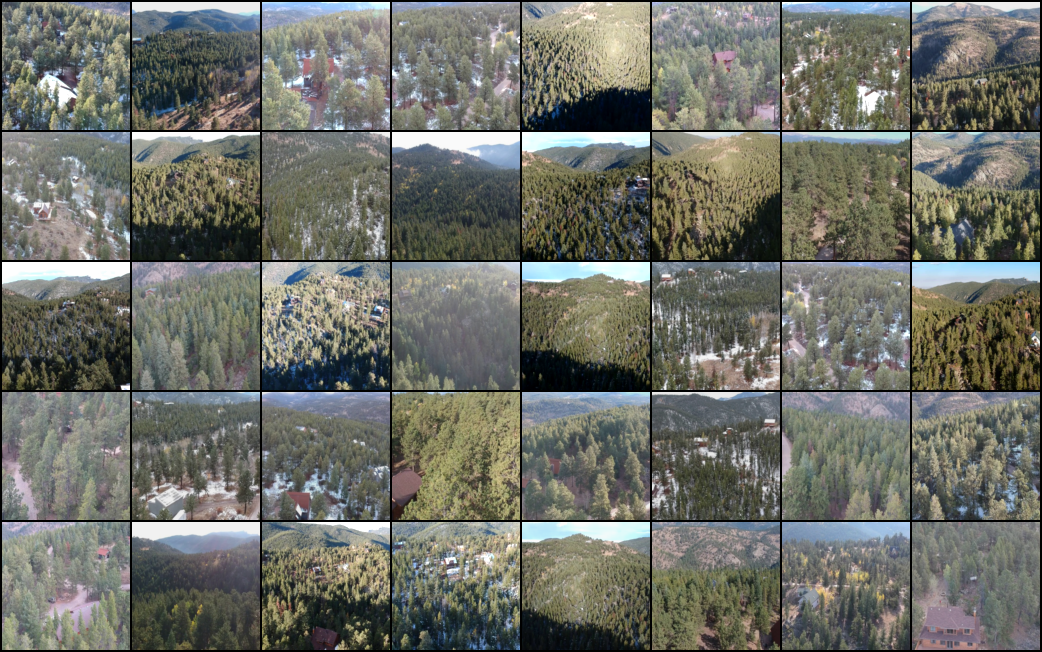

In [4]:
# sample batch
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [5]:
# GAN CREATION
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x
      
class DCGAN_D(nn.Module):
    # image size, number of channels in image, number of channels out in next layer, number of extra layers
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1) # returns the mean prediction for all images in batch

In [6]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"
        
        self.drop_z = nn.Dropout(p=0.1)
        
        cngf, tisize = ngf//2, 4 # This is original
        #cngf, tisize = ngf//2, 8 # RG 9.13 reducing size of network
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, z_seq): 
        z_seq = self.drop_z(z_seq)
        out = F.sigmoid(self.features(z_seq)) # changed this to Sigmoid to force to 0 to 1
        return out
  

In [7]:
# Make GAN components

# batch size, size of image, size of latent vector z
sz,nz = SZ, 600
num_channels = 3

# image size, number of channels, number of channels in next layer, number of extra layers
#netD = DCGAN_D(sz, num_channels, 64, 1).cuda()

netG = DCGAN_G(sz, nz, num_channels, 64).cuda()

# BOTH INLINNE AND NOT CUDA-FY the MODEL

In [8]:
# Verify that model is cuda-fied
next(netG.parameters()).is_cuda

True

In [9]:
# get size of model

total_params = sum(p.numel() for p in netG.parameters()); print("total params", total_params)

total params 20978560


In [10]:
netG

DCGAN_G(
  (drop_z): Dropout(p=0.1)
  (features): Sequential(
    (0): DeconvBlock(
      (conv): ConvTranspose2d(600, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (1): DeconvBlock(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (2): DeconvBlock(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (3): DeconvBlock(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tra

In [13]:
# takes in batch size, returns random of shape batch size, size of latent z, 1, 1
def create_noise(b): return torch.zeros(b, nz, 1, 1).normal_(0, 1).cuda()

In [14]:
create_noise(4).shape

torch.Size([4, 600, 1, 1])

In [37]:
# testing out flow 
latents = create_noise(4)
gens = netG(latents); print(gens.shape) # returns a batch of generated images
preds = netD(gens); print(preds) # returns a single number, mean of preds for all images in batch

torch.Size([4, 3, 128, 128])
tensor([0.0293], device='cuda:0', grad_fn=<ViewBackward>)


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([4, 3, 128, 128])
torch.Size([1, 3, 128, 128])


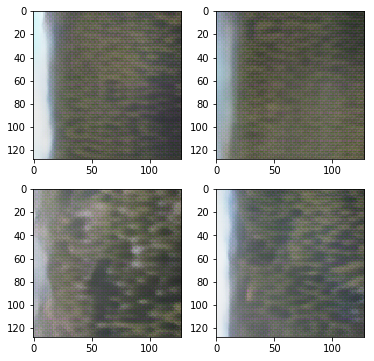

In [45]:
# Evaluating GAN generator from random latent

netG.eval()

latents = create_noise(4)
gens = netG(latents); print(gens.shape) # returns shape batch size, num channels, image height, image width

# returns shape 1, num channels, height by width. Same as above, but batch size of one.
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0); print(fixed_x.shape)

#pred_ims = md.trn_ds.denorm(preds) Changed Generator to output sigmoid rather than tanh, forcing output to 0, 1 range

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

# this one for three channels
for i,ax in enumerate(axes.flat): ax.imshow(gens[i].transpose(0,2).detach().cpu().numpy())
    
# this one for 1 channel
#for i,ax in enumerate(axes.flat): ax.imshow(gens[i].squeeze(0).detach().cpu().numpy())


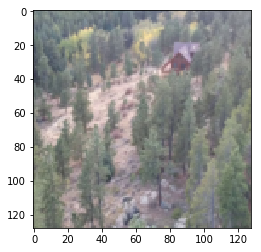

In [11]:
# Another way of showing sample image, in addition to other "save file, open again" method used below and above.

# for one channel
#sample = dataset[0][0].squeeze(0)

# for 3 channels
sample = dataset[10][0].permute(1,2,0).detach().cpu().numpy()

plt.imshow(sample);

In [11]:
next(iter(dataloader))[0].shape

torch.Size([40, 3, 128, 128])

## Resnet encoder

In [11]:
resnet18 = torchvision.models.resnet18(True)

resnet_backbone = nn.Sequential(*[l for l in resnet18.children()][:-2]) # have to take off avgpool layer and swap w stride 2
set_trainable(resnet_backbone, False) # Don't train resnet backbone

class Encoder(nn.Module):
    def __init__(self, image_channels=3, h_dim=512, z_dim=100): # hardcoding h_dim based on how flat final step is, which depends on input img sz
        super(Encoder, self).__init__()
        self.h_dim=h_dim
        self.resnet = resnet_backbone
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=2, padding=0) # same avgpool as before, but stride 2 to fit 256
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.resnet(x)
        h = self.avgpool(h).squeeze_(3).squeeze_(2)
        
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

## DCGAN encoder

In [11]:
h_dim = 16384 #8192#16384 #32768; # this results from img sz and model architecture
z_dim = nz;

class Encoder(nn.Module):
    # image size, number of channels in image, number of channels out in next layer, number of extra layers
    def __init__(self, isize, nc, ndf):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf

        pyr_layers = []
        while csize > 4:
        #while csize > 8:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        #self.bn1 = nn.BatchNorm1d(z_dim)
        
        self.fc2 = nn.Linear(h_dim, z_dim)
        #self.bn2 = nn.BatchNorm1d(z_dim)

    def forward(self, input):
        x = self.initial(input)
        x = self.pyramid(x)
        global h
        h = x.view(x.size(0), -1) # flatten 
        mu, logvar = self.fc1(h), self.fc2(h)
        logvar = torch.clamp(logvar, -6, 6)
        
        #mu, logvar = self.bn1(h1), self.bn2(h2)
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    

In [12]:
encoder = Encoder(SZ, 3, 64).cuda() # using 16 to make model smaller. JH had 64

In [13]:
# get size of model

total_params = sum(p.numel() for p in encoder.parameters()); print("total params", total_params)

total params 30810032


In [14]:
encoder

Encoder(
  (initial): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace)
  )
  (pyramid): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): ConvBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace)
    )
 

In [15]:
# Testing feature loss
sample_batch = next(iter(dataloader))[0].cuda()

In [16]:
z, mu, logvar = encoder(sample_batch)

In [17]:
logvar = torch.clamp(logvar, -6, 6)
std = logvar.mul(0.5).exp_()

mu.max(), logvar.max(), std.max()

(tensor(1.5633, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.8394, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(2.5085, device='cuda:0', grad_fn=<MaxBackward1>))

In [18]:
z.shape

torch.Size([40, 600])

In [19]:
logvar.std()

tensor(0.3328, device='cuda:0', grad_fn=<StdBackward0>)

## VAE

In [71]:
fixed_x.size()

torch.Size([1, 3, 256, 256])

In [72]:
# vae was here

In [7]:
image_channels = fixed_x.size(1)
image_channels

vae = VAE(image_channels=image_channels)

if torch.cuda.is_available():
    print("cuda available")
    vae.cuda()

cuda available


In [38]:
# VAE optimizer

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4) 

NameError: name 'vae' is not defined

## Feature loss

In [25]:
# Grabbing a portion of vgg16_bn to act as model for featureloss

m_vgg = torchvision.models.vgg16_bn(True)

b = list(children(m_vgg)[0])
blocks = [i-1 for i,o in enumerate(b)
              if isinstance(o,nn.MaxPool2d)]
print(blocks, [b[i] for i in blocks])

vgg_layers = b[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

[5, 12, 22, 32, 42] [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)]


In [26]:
blocks

[5, 12, 22, 32, 42]

In [27]:
class FeatureLoss(nn.Module):
    # takes in two images, one real and one generated. Computes features loss on them.
    
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True): 
        # Input is the OUTPUT of our model. It's the pic we tried to make. target is the image itself. 
        # We run our reconstruction and our target/original through the same VGG16 and try to make our reconstruction
        # activate the same FEATURES as the original does.
        
        # We're not trying to influence the activations of our network directly, as i thought earlier. We're running the image
        # through as normal, then using this feature loss afterwards in place of pixel loss, or alongside pixel loss.
        
        #print(input.shape, target.shape)
        self.m(target.data)
        #res = [F.l1_loss(input,target)/100] 
        res = [0]
        targ_feat = [o.features.data.clone() for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

def flatten(x): return x.view(x.size(0), -1)

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove() 

In [28]:
feature_loss = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

In [29]:
# Two of same image should be feature loss of ZERO
feature_loss(sample_batch, sample_batch)

tensor(0., device='cuda:0')

In [30]:
z, mu, logvar = encoder(sample_batch)
gens = netG(pad_z(z))

feature_loss(gens, sample_batch)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0569, device='cuda:0', grad_fn=<ThAddBackward>)

## Training loop

In [65]:

LR = 1e-4
WD = 1e-6
# Encoder optimizer
optimizer_encoder = torch.optim.RMSprop(encoder.parameters(), lr=LR, weight_decay=WD) 

# GAN optimizers
#optimizerD = torch.optim.RMSprop(netD.parameters(), lr = LR)
optimizerG = torch.optim.RMSprop(netG.parameters(), lr = LR, weight_decay=WD)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 1 vae_loss tensor(0.0031, device='cuda:0') KL loss tensor(2.8056, device='cuda:0') feature_loss tensor(0.0406, device='cuda:0')
z max, min 4.858189105987549 -4.798762321472168
torch.Size([1, 600]) torch.Size([1, 3, 128, 128])


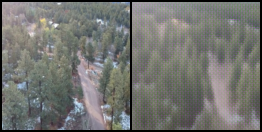

In [ ]:
# Train VAE with Feature Loss. CURRENT BEST PERFORMANCE.

#set_trainable(vae, True) DOING RESNET ENCODER

train_VAE = True; #train_D = False;
ACCUMULATION_STEPS = 2 # multiply this by bs to get true bs for parameter update

epochs = 100
log_interval = 1000
for epoch in range(epochs):
    optimizer_encoder.zero_grad()
    optimizerG.zero_grad()
            
    for idx, (images, _) in enumerate(dataloader):
        """
        if train_D:
            #####################################
            #  Train D
            #####################################
            set_trainable(encoder, False); set_trainable(netG, False); set_trainable(netD, True)
            netD.train()

            for p in netD.parameters(): p.data.clamp_(-0.01, 0.01) # this is the money-shot for W gan. 
            real = images.cuda()
            # Outputs single number. bigger number means bigger probability of fake. 
            # These images are real, so from D's perspective number SHOULD be low
            real_loss = netD(real) 

            z, mu, logvar = encoder(real)
            fake = netG(pad_z(z))
            
            # From D's perspective this SHOULD be big bc we know these are fakes
            fake_loss = netD(fake.data)  
            netD.zero_grad()
            lossD = real_loss-fake_loss # real_loss SHOULD be small, fake_loss SHOULD be big. real loss should be called fakeness_estimate_real, fake loss called fakeness_estimate_fake
            lossD.backward()
            optimizerD.step()
            
            if idx % log_interval == 0: print(real_loss.data, fake_loss.data, lossD.data)"""
        
        if train_VAE:
            #####################################
            #  Train Encoder Decoder
            #####################################
            set_trainable(encoder, True); set_trainable(netG, True); #set_trainable(netD, False)
            netG.train(); encoder.train() # back to train mode

            z, mu, logvar = encoder(images.cuda())
            recon_images = netG(pad_z(z))

            vae_loss, bce, kld = loss_fn(recon_images.cuda(), images.cuda(), mu.cuda(), logvar.cuda())
            vae_loss /= 4e8

            f_loss = feature_loss(recon_images.cuda(), images.cuda())
            
            # From perspective of G, want this to be LOW. Want to trick D into thinking it's real
            #gan_loss = netD(recon_images)
            #gan_loss /= 100

            total_loss = vae_loss + f_loss #+ gan_loss
            total_loss /= ACCUMULATION_STEPS
            
            total_loss.backward()
            if (idx+1) % ACCUMULATION_STEPS == 0:
                optimizerG.step()
                optimizer_encoder.step()
                
                optimizer_encoder.zero_grad()
                optimizerG.zero_grad()
        
            if idx % log_interval == 0:
                print('\n', epoch+1, "vae_loss", vae_loss.data, "KL loss", kld.data, "feature_loss", f_loss.data)
                print("z max, min", z.max().detach().item(), z.min().detach().item())
                #for p in encoder.parameters(): print(p.max())
                #for p in netG.parameters(): print(p.max())
                
                torch.save(encoder.state_dict(), 'encoder_128.torch')
                torch.save(netG.state_dict(), 'netG_128.torch')

                with torch.no_grad():
                    fixed_x = dataset[randint(1, len(dataset)-1)][0].unsqueeze(0);
                    compare_x = compare(fixed_x)
                    save_image(compare_x.data.cpu(), 'sample_image.png')
                    display(Image('sample_image.png', width=800, unconfined=True))

In [67]:
# Saving parameters.

#torch.save(encoder.state_dict(), 'encoder_128.torch')
#torch.save(netG.state_dict(), 'netG_128.torch')

In [20]:
# Reloading from saved model. 9.3 is feature loss 256
encoder.load_state_dict(torch.load("encoder_128.torch"))
netG.load_state_dict(torch.load("netG_128.torch"))
"""
encoder.load_state_dict(torch.load("encoder_256_small.torch"))
netG.load_state_dict(torch.load("netG_256_small.torch"))"""
#netD.load_state_dict(torch.load("netD.torch"))

'\nencoder.load_state_dict(torch.load("encoder_256_small.torch"))\nnetG.load_state_dict(torch.load("netG_256_small.torch"))'

torch.Size([1, 3, 128, 128])
torch.Size([1, 600]) torch.Size([1, 3, 128, 128])


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


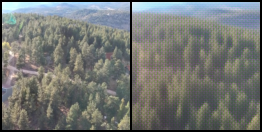

In [21]:
# testing quality of vae compression. Can use VAE decoder or GAN G.
def compare(x):
    #vae.eval(); netG.eval()
    encoder.eval(); netG.eval()
    #z, mu, logvar = vae.encode(x.cuda())
    z, mu, logvar = encoder(x.cuda())
    recon_x = netG(pad_z(z))
        
    print(z.shape, recon_x.shape)
    return torch.cat([x.cpu(), recon_x.cpu()])

fixed_x = dataset[randint(1, len(dataset)-1)][0].unsqueeze(0); print(fixed_x.shape)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=900, unconfined=True))

## Integration w MDN, video construction apparatus

#### Creating and saving z seq

In [74]:
# Generate ordered reconstructions and latents

#vae.eval()
encoder.eval()
netG.eval()

zs = []
with torch.no_grad():
    for idx, (images, _) in enumerate(dataloader_ordered):
        print("i")
        #z, mu, logvar = vae.encode(images.cuda())
        z, mu, logvar = encoder(images.cuda())
        zs.append(z.data.data.cpu().numpy())
        

i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i


i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i


In [85]:
# Join batches into single z seq

z_seq = np.concatenate(zs, axis=0)
z_seq.shape

(256029, 600)

In [86]:
# Saving ENTIRE sequence, no splitting inter smaller seqs
# 9.7 full seq from 1.5 min updown
# 9.10 6 min updown
# 9.13 6 min updown smaller Gen
# 9.21 is 30 min of clearing 
torch.save(z_seq, "z_seq_sequential.pt")

In [30]:
# SAMPLING shorter z seqs from single z seq. Saving to larger dataset of smaller seqs. DOING THIS IN RNN NOTEBOOK NOW

N_SEQS = 3000
SEQ_L = 222
seqs = []
for i in range(N_SEQS):
    start_ix = randint(0, len(z_seq)-SEQ_L)
    #seqs.append(z_seq[start_ix:start_ix+SEQ_L])
    seqs = torch.cat(seqs, z_seq[start_ix:start_ix+SEQ_L])
    
# Saving seqs to hand off to MDN

seqs = torch.FloatTensor(np.array(seqs))

torch.save(seqs, "z_seq_samples_9.7.pt")
# 9.4 trained w 256 x 256
seqs.shape

torch.Size([3000, 222, 100])

#### Loading actions

In [22]:
# getting actions to line up w frames
actions_sequential = torch.load("actions_sequential.pt"); print(actions_sequential.shape)

torch.Size([229044, 1])


In [23]:
def discretize(x):
    if x > 0: return 1
    elif x == 0: return .5
    else: return 0
    
actions_sequential.apply_(discretize)

"""
actions_sequential -= actions_sequential.min()
actions_sequential /= actions_sequential.max()
actions_sequential.max()"""

'\nactions_sequential -= actions_sequential.min()\nactions_sequential /= actions_sequential.max()\nactions_sequential.max()'

In [24]:
actions_sequential.min(), actions_sequential.max()

(tensor(0.), tensor(1.))

#### Loading generated z seq preds back from LSTM

In [25]:
# Got back from MDN-RNN

#gen_z = torch.load('gen_z_seq.pt') # real gen seq
gen_z = torch.tensor(torch.load("z_seq_sequential.pt")) #actually just testing original z seq

In [26]:
#gen_z = gen_z[:actions_sequential.size(0)]
gen_z.shape

torch.Size([229044, 600])

torch.Size([1, 3, 128, 128])


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


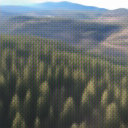

In [30]:
# Testing a single generated z
with torch.no_grad():
    netG.eval()
    z = torch.tensor(gen_z[randint(0,gen_z.size(0))]).unsqueeze(0).cuda()
    reconstructed = netG(pad_z(z))
    print(reconstructed.shape)

    save_image(reconstructed.data.cpu(), 'sample_image.png')
    display(Image('sample_image.png', width=300, unconfined=True))

In [ ]:
# Decoding generated pred z sequence to images, prepped for np and cv2

ix = 0
bs = 30
z_gen = pad_z(gen_z.cuda())
preds = []
netG.eval()
with torch.no_grad():
    while ix < z_gen.size(0):
        print(ix)
        batch = z_gen[ix:ix+bs]
        pred = netG(batch).cpu().detach().numpy()
        pred = np.transpose(pred, (0, 2, 3, 1)) # prep axis numpy style
        pred[:, :25,:25, :] = actions_sequential[ix:ix+bs].unsqueeze(1).unsqueeze(1) # add colored swathe for action
        pred = np.uint8(pred*255)
        preds.append(pred)
        ix+=bs
        
preds = np.concatenate(preds, axis=0); print(preds.shape)

0
30


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500
1530
1560
1590
1620
1650
1680
1710
1740
1770
1800
1830
1860
1890
1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340
2370
2400
2430
2460
2490
2520
2550
2580
2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030
3060
3090
3120
3150
3180
3210
3240
3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600
3630
3660
3690
3720
3750
3780
3810
3840
3870
3900
3930
3960
3990
4020
4050
4080
4110
4140
4170
4200
4230
4260
4290
4320
4350
4380
4410
4440
4470
4500
4530
4560
4590
4620
4650
4680
4710
4740
4770
4800
4830
4860
4890
4920
4950
4980
5010
5040
5070
5100
5130
5160
5190
5220
5250
5280
5310
5340
5370
5400
5430
5460
5490
5520
5550
5580
5610
5640
5670
5700
5730
5760
5790
5820
5850
5880
5910
5940
5970
6000
6030
6060
6090
6120
6150
6180
6210
6240

In [ ]:
# Stitching frames back together into video. TAKEN FROM VIDEO PROCESSING notebook

reconstructed = preds

img1 = reconstructed[0]
height , width , layers =  img1.shape
fps = 30

video = cv2.VideoWriter('lazy_overview.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(reconstructed)-1):
    img = reconstructed[i] # cv2 expects out of 255, integers
    video.write(img)
    
cv2.destroyAllWindows()
video.release()

## Evaluation: Encoding z with VAE, generating w netG based on z.

In [72]:
# VAE encoder
real = dataset[randint(0,2000)][0]; print(real.shape)
fixed_x = real.unsqueeze(0); print("image_shape", fixed_x.shape)
z, _, _ = vae.encode(fixed_x.cuda());

torch.Size([3, 256, 256])
image_shape torch.Size([1, 3, 256, 256])


In [73]:
# Resize z
z_pad = z.unsqueeze(2).unsqueeze(3)
z_pad.shape

torch.Size([1, 100, 1, 1])

In [74]:
# Generate based on z
netG.eval()
gen = netG(z_pad).squeeze(0)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


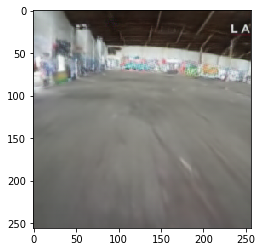

In [75]:
# Resize to show gen image
gen_np = gen.permute(1,2,0).detach().cpu().numpy()
plt.imshow(gen_np);

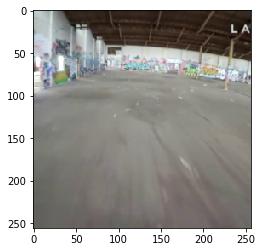

In [76]:
# real image for comparison

real_np = real.permute(1,2,0).detach().cpu().numpy()
plt.imshow(real_np);

In [77]:
netD(real.unsqueeze(0).cuda()), netD(gen.unsqueeze(0).cuda())

(tensor([0.2204], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([0.0215], device='cuda:0', grad_fn=<ViewBackward>))